# Supervised Learning Approach

(Insert explanation of our process here)

## Supervised Learning Approach

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 10
BATCH_SIZE = 20

### Reading Stock Data

In [2]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")

In [3]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


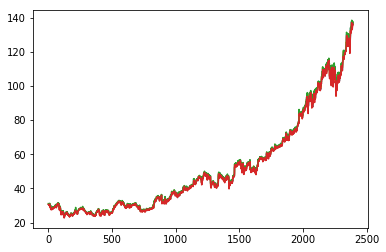

In [4]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

In [5]:
df_train, df_test = train_test_split(msft, train_size=0.84, test_size=0.16, shuffle=False)

In [6]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [7]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2009,2017-12-26,85.31,85.53,85.03,85.40,83.28,9891200
2010,2017-12-27,85.65,85.98,85.22,85.71,83.58,14678000
2011,2017-12-28,85.90,85.93,85.55,85.72,83.59,10594300
2012,2017-12-29,85.63,86.05,85.50,85.54,83.42,18717400
2013,2018-01-02,86.13,86.31,85.50,85.95,83.82,22483800


In [8]:
train_cols = ["Open", "High", "Low", "Close", "Volume"]
print("Train and Test Size:", len(df_train), len(df_test))
x = df_train.drop(columns=["Date"]).values
min_max_scaler = MinMaxScaler()

# Transforming Data
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.fit_transform(df_test.drop(columns=["Date"]).values)

Train and Test Size: 2009 383


In [9]:
x_train.shape, x_test.shape

((2009, 6), (383, 6))

## Build Time-Series Structure

In [24]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


length of time-series i/o (1999, 10, 6) (1999,)
length of time-series i/o (373, 10, 6) (373,)
Test size (180, 10, 6) (180,) (180, 10, 6) (180,)


In [25]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [26]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
print(history)


Train on 1980 samples, validate on 180 samples
Epoch 1/50
 - 2s - loss: 0.0092 - val_loss: 0.4369
Epoch 2/50
 - 1s - loss: 0.0311 - val_loss: 0.3748
Epoch 3/50
 - 1s - loss: 0.0186 - val_loss: 0.2718
Epoch 4/50
 - 1s - loss: 0.0114 - val_loss: 0.1586
Epoch 5/50
 - 1s - loss: 0.0058 - val_loss: 0.1249
Epoch 6/50
 - 1s - loss: 0.0048 - val_loss: 0.0930
Epoch 7/50
 - 0s - loss: 0.0038 - val_loss: 0.0951
Epoch 8/50
 - 1s - loss: 0.0031 - val_loss: 0.0928
Epoch 9/50
 - 1s - loss: 0.0032 - val_loss: 0.0827
Epoch 10/50
 - 1s - loss: 0.0023 - val_loss: 0.0987
Epoch 11/50
 - 0s - loss: 0.0023 - val_loss: 0.0837
Epoch 12/50
 - 0s - loss: 0.0020 - val_loss: 0.0669
Epoch 13/50
 - 1s - loss: 0.0019 - val_loss: 0.0649
Epoch 14/50
 - 1s - loss: 0.0017 - val_loss: 0.1212
Epoch 15/50
 - 1s - loss: 0.0016 - val_loss: 0.1017
Epoch 16/50
 - 1s - loss: 0.0014 - val_loss: 0.2352
Epoch 17/50
 - 1s - loss: 0.0063 - val_loss: 0.0563
Epoch 18/50
 - 1s - loss: 0.0013 - val_loss: 0.0567
Epoch 19/50
 - 1s - loss: 

In [27]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.005687405734595098 (180,) (180,)
[116.31368  116.377975 116.2444   116.695885 116.88372  116.98125
 115.91638  114.783035 113.465744 114.01675  111.14244  108.02416
 110.428535 110.79355  112.61435 ]
[114.41 114.37 115.61 115.15 115.17 112.79 112.13 110.85 112.26 106.16
 105.91 109.57 107.6  111.   110.71]


<Figure size 432x288 with 0 Axes>

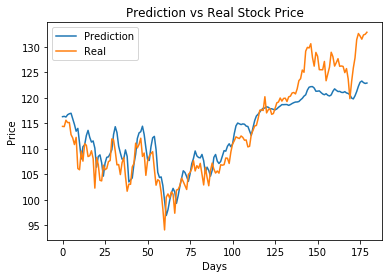

<Figure size 432x288 with 0 Axes>

In [30]:
from matplotlib import pyplot as plt
plt.figure()
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# #plt.show()
# plt.savefig( 'train_vis_BS_.png')

from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig('pred_vs_real_BS_.png')


In [37]:
y_prev = None
y_pred_prev = None
profits = 0
for y_pred, y in zip(y_pred_org, y_test_t_org):
    if y_prev is None and y_pred_prev is None:
        pass
    else:
        change = y-y_prev
        if change > 0:
            if y_pred > y_pred_prev:
                profits -= change
            elif y_pred < y_pred_prev:
                profits += change
        elif change < 0: 
            if y_pred < y_pred_prev:
                profits -= change
            elif y_pred > y_pred_prev:
                profits += change
        #print(y_pred, y, profits)
    y_prev = y
    y_pred_prev = y_pred
print(profits)

from keras import backend as K

def coeff_determination(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

R_2 = coeff_determination(y_test_t_org, y_pred_org)
with tf.Session() as sess:  
    print(R_2.eval()) 


-7.260000000000105
0.8136978832648585


## Reinforcement Learning Approach (Q-Learning)

### Create Environment for ML Agent

In [75]:
class Environment:
    def __init__(self, data, h_t=90):
        self.data = data
        self.h_t = h_t
        self.reset()
    
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0 
        self.positions = [] # list of current stocks with the trading bot
        self.position_val = 0
        self.history = [0 for _ in range(self.h_t)]
        return [self.position_val] + self.history
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [76]:
env = Environment(df_train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print (pact)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010000000000001563], -1, False)
2
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.010000000000001563, -0.19000000000000128], -1, False)
0
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [77]:
class Q_Network:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()     
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
        